In [1]:
%load_ext autoreload
%autoreload 1

#%aimport tardisml_utils

In [3]:
import xarray as xr
import os
import pandas as pd
from src.data_preparation.loada import loada_seq
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import yaml


In [5]:
import src.utils.tardisml_utils as tardisml_utils #, nosit_dir, withsit_dir, forcing_adir, forcing_bdir, forcing_fields #TODO put in yaml file
# lim_idm=(200,600) 
# lim_jdm=(600,881)
n_components = 8 #TODO: have a different number for each type a variable
idate = 100 # Date to plot in example


In [7]:
template = yaml.load(open('../config/template_name.yaml'),Loader=yaml.FullLoader)
template

{'dailync': 'TP4DAILY_{year:04d}_{dayinyear:03d}.nc',
 'dailync_full': '{year:04d}{month:02d}{day:02d}_dm-12km-NERSC-MODEL-TOPAZ4B-ARC-RAN.fv2.0.nc'}

TP4 stands for TOPAZ v4

In [8]:
config = yaml.load(open('../config/data_proc_demo.yaml'), Loader=yaml.FullLoader)

nosit_dir = config['user'] + config['nosit_dir']
withsit_dir = config['user'] + config['withsit_dir']
forcing_bdir = config['user'] + config['forcing_bdir']

timeofday = config['timeofday']
target_field = config['target_field']
forcing_fields = config['forcing_fields']
lim_idm = config['lim_idm']
lim_jdm = config['lim_jdm']

config

{'covariable_fields': ['fice00',
  'hsnw00',
  'ssh00',
  'vice00',
  'uice00',
  'swflx00'],
 'fig_dir': '/figures/',
 'forcing_adir': '/Jiping/dailyforcing_2014_2017',
 'forcing_bdir': '/forcings',
 'forcing_fields': ['airtmp',
  'mslprs',
  'vapmix',
  'precip',
  'wndewd',
  'wndnwd',
  'radflx',
  'shwflx'],
 'forcing_mean_days': 21,
 'lim_idm': (200, 600),
 'lim_jdm': (600, 881),
 'ml': 'xgb',
 'ml_dir': '/ml/',
 'nosit_dir': '/Jiping/dailync_NoSIT/',
 'nseq': 22,
 'para_var_dpd': {'History': [1, 3, 3, 3],
  'History_neg': [0, 0, 0, 0],
  'description': 'dictionary contains all parameters that vary for each type of variables',
  'n_components': [4, 4, 4, 4],
  'type_var_short': ['tp', 'nc', 'fo', 'co'],
  'type_variable': ['target_predict_var',
   'non_corrected_var',
   'forcings',
   'covariables']},
 'pca_dir': '/results/pca_i200-600_j600-881',
 'results_dir': '/results/xgb_Npred22_8F_rw21d_N4444_H1333_Hn0000_hice00_artc_220919-162316',
 'target_field': 'hice00',
 'timeofday':

In [9]:
forcing_fields


['airtmp',
 'mslprs',
 'vapmix',
 'precip',
 'wndewd',
 'wndnwd',
 'radflx',
 'shwflx']

- mslprs: Mean sea-level pressure
- airtmp: Air temperature

## Define chronology

In [10]:
# The chronology is the same for all forcing fields
# Just take the first one

df = pd.read_pickle(os.path.join(rootdir,forcing_bdir,f'{forcing_fields[0]}.pkl'))
chrono = df[df.time%1==timeofday].date

chrono.iloc[idate]

NameError: name 'rootdir' is not defined

## Load SIT (Sea Ice Thickness)

In [8]:
nc1 = xr.open_dataset(os.path.join(rootdir, withsit_dir, 'TP4DAILY_2014_000.nc'))
nc1.fyear

<xarray.DataArray 'fyear' (rdim: 1)>
array([2014.0328], dtype=float32)
Dimensions without coordinates: rdim

### 1) PCA of SIT with no sit assimilation:

In [9]:
list_files = [os.path.join(rootdir, nosit_dir, template['dailync'].format(year=date.year, dayinyear = date.dayofyear-1)) for date in chrono]
missing = [os.path.basename(file) for file in list_files if not os.path.isfile(file)]

if len(missing)>0:
    print('hack for missing files')
    with open(os.path.join(rootdir, nosit_dir, 'missing.yaml'),'w') as f:
        yaml.dump(missing, f)
    for file in list_files:
        if os.path.isfile(file):
            last_ok_file = file
        else:
            os.symlink(last_ok_file, file)

        

In [10]:

nc_f = xr.open_mfdataset(list_files, combine='nested', concat_dim='rdim')

In [11]:
nc_f

<xarray.Dataset>
Dimensions:    (rdim: 1461, jdim: 880, idim: 800)
Dimensions without coordinates: rdim, jdim, idim
Data variables: (12/31)
    longitude  (rdim, jdim, idim) float32 dask.array<chunksize=(1, 880, 800), meta=np.ndarray>
    latitude   (rdim, jdim, idim) float32 dask.array<chunksize=(1, 880, 800), meta=np.ndarray>
    dx         (rdim, jdim, idim) float32 dask.array<chunksize=(1, 880, 800), meta=np.ndarray>
    dy         (rdim, jdim, idim) float32 dask.array<chunksize=(1, 880, 800), meta=np.ndarray>
    depth      (rdim, jdim, idim) float32 dask.array<chunksize=(1, 880, 800), meta=np.ndarray>
    fyear      (rdim) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ...         ...
    ubavg00    (rdim, jdim, idim) float32 dask.array<chunksize=(1, 880, 800), meta=np.ndarray>
    vbavg00    (rdim, jdim, idim) float32 dask.array<chunksize=(1, 880, 800), meta=np.ndarray>
    uice00     (rdim, jdim, idim) float32 dask.array<chunksize=(1, 880, 800), meta=np.ndarray>
    vice00     (rdim, jdim, idim) float32 dask.array<chunksize=(1, 880, 800), meta=np.ndarray>
    utot01     (rdim, jdim, idim) float32 dask.array<chunksize=(1, 880, 800), meta=np.ndarray>
    vtot01     (rdim, jdim, idim) float32 dask.array<chunksize=(1, 880, 800), meta=np.ndarray>
Attributes:
    title:                    tecconv generated fields
    Dataset_generation_date:  20180807
    history:                  Created 20180807 by program tecconv
    Conventions:              -

In [12]:
nc_f_sel = nc_f[target_field].sel(jdim=slice(*lim_jdm),idim=slice(*lim_idm))

In [13]:
mu_f =  nc_f_sel.mean(dim='rdim').compute()

In [14]:
Xf = nc_f_sel.compute()
# fyear is not relevant

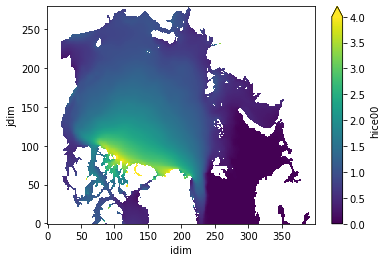

In [15]:
mu_f.plot(vmax=4)

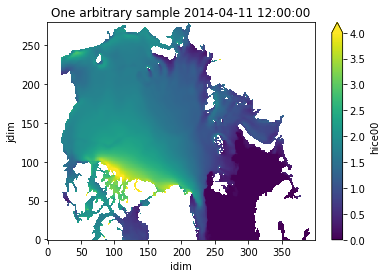

In [16]:
Xf.isel(rdim=idate).plot(vmax=4)
plt.title(f'One arbitrary sample {chrono.iloc[idate]}');

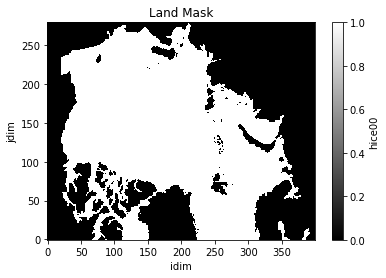

In [17]:
#TODO : redo by combinbing forecast and analyis mask (even though they should be the same)
maskok = (np.isfinite(Xf)).all(dim='rdim')
maskok.plot(cmap=plt.get_cmap('gray'));
mskok1d= maskok.stack(z=('jdim','idim'))
plt.title('Land Mask');

In [18]:
Xf1d =  Xf.stack(z=('jdim','idim'))


In [19]:
Xf1d_nonan = Xf1d.where(mskok1d, drop=True)
Xf1d_nonan.shape

(1461, 60643)

In [20]:
#TODO: PCA only on training
pca_f = PCA(n_components=n_components)
pca_f.fit(Xf1d_nonan)

PCA(n_components=8)

In [21]:
pca_f.components_.shape
PCs_f = xr.DataArray(pca_f.transform(Xf1d_nonan), dims=['rdim','comp'])

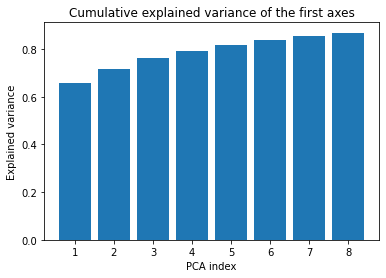

In [22]:
plt.bar(x=np.arange(n_components)+1,height=pca_f.explained_variance_ratio_.cumsum());
plt.title('Cumulative explained variance of the first axes')
plt.xlabel('PCA index')
plt.ylabel('Explained variance');

In [23]:
EOF1d = xr.DataArray(np.nan*np.ones ((n_components,Xf1d.shape[1])),dims=['comp','z'])
multi_index = pd.MultiIndex.from_tuples(Xf1d.coords['z'].data,names=['jdim','idim'])
EOF1d = EOF1d.assign_coords(z=('z',multi_index))
EOF1d[{'z':mskok1d}] = pca_f.components_
EOF2d= EOF1d.unstack('z')

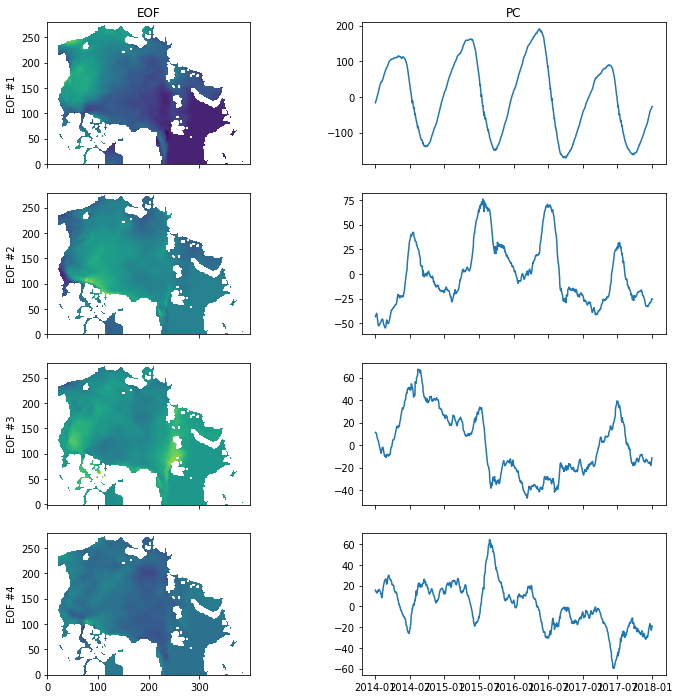

In [24]:
max_plot = 4
fig, ax = plt.subplots(ncols=2, nrows=max_plot,sharex='col', figsize=(12,max_plot*3))
for i in range(max_plot):
    ax[i, 0].imshow(EOF2d.isel(comp=i),origin='lower')
    ax[i, 1].plot(chrono, PCs_f[:,i])
    ax[i, 0].set_ylabel(f'EOF #{i+1}')
    
ax[0,0].set_title('EOF')
ax[0,1].set_title('PC');

In [25]:
# Reconstruction TODO use inverse transform/kernel PCA ?
Xf_rec = xr.dot(EOF2d,PCs_f)+ mu_f

# Reoconstruction 3 EOF
Xf_rec3 = xr.dot(EOF2d.isel(comp=slice(0,3)),PCs_f.isel(comp=slice(0,3))) + mu_f

Text(0.5, 1.0, 'REC - TOPAZ')

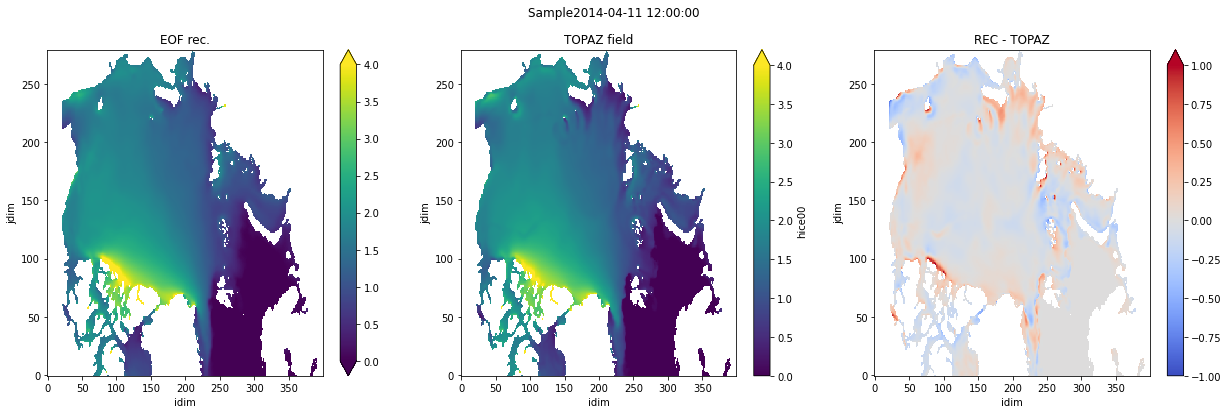

In [26]:
fig, ax = plt.subplots(ncols=3, figsize=(21,6))
fig.suptitle(f'Sample{chrono.iloc[idate]}')
Xf_rec.isel(rdim=idate).plot(ax=ax[0],vmin=0, vmax=4)
Xf.isel(rdim=idate).plot(ax=ax[1],vmin=0, vmax=4)
(Xf_rec-Xf).isel(rdim=idate).plot(ax=ax[2], vmin=-1, vmax=1, cmap=plt.get_cmap('coolwarm'))
ax[0].set_title('EOF rec.')
ax[1].set_title('TOPAZ field')
ax[2].set_title('REC - TOPAZ')


In [27]:
RMSE_recf = np.sqrt((np.square(Xf_rec-Xf)).mean(dim='rdim'))


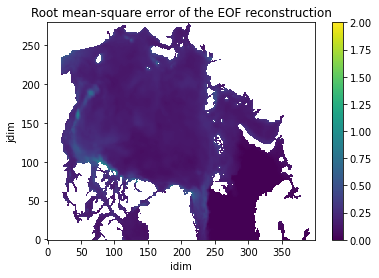

In [28]:
RMSE_recf.plot(vmax=2)
plt.title('Root mean-square error of the EOF reconstruction');

### 2) PCA of SIT with sit assimilation (reference field)
Actually we don't represent the PCA of the SIT field but the PCA of the difference between SIT (with DA) and SIT (no DA), called 'model error'

In [29]:
list_files_a = [os.path.join(rootdir, withsit_dir, template['dailync'].format(year=date.year, dayinyear = date.dayofyear-1)) for date in chrono]
missing = [os.path.basename(file) for file in list_files if not os.path.isfile(file)]

if len(missing)>0:
    print('hack for missing files')
    with open(os.path.join(rootdir, nosit_dir, 'missing.yaml'),'w') as f:
        yaml.dump(missing, f)
    for file in list_files:
        if os.path.isfile(file):
            last_ok_file = file
        else:
            os.symlink(last_ok_file, file)


In [30]:
nc_a = xr.open_mfdataset(list_files_a, combine='nested', concat_dim='rdim')

In [31]:
nc_a

<xarray.Dataset>
Dimensions:    (rdim: 1461, jdim: 880, idim: 800)
Dimensions without coordinates: rdim, jdim, idim
Data variables: (12/33)
    longitude  (rdim, jdim, idim) float32 dask.array<chunksize=(1, 880, 800), meta=np.ndarray>
    latitude   (rdim, jdim, idim) float32 dask.array<chunksize=(1, 880, 800), meta=np.ndarray>
    dx         (rdim, jdim, idim) float32 dask.array<chunksize=(1, 880, 800), meta=np.ndarray>
    dy         (rdim, jdim, idim) float32 dask.array<chunksize=(1, 880, 800), meta=np.ndarray>
    depth      (rdim, jdim, idim) float32 dask.array<chunksize=(1, 880, 800), meta=np.ndarray>
    fyear      (rdim) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ...         ...
    ubavg00    (rdim, jdim, idim) float32 dask.array<chunksize=(1, 880, 800), meta=np.ndarray>
    vbavg00    (rdim, jdim, idim) float32 dask.array<chunksize=(1, 880, 800), meta=np.ndarray>
    uice00     (rdim, jdim, idim) float32 dask.array<chunksize=(1, 880, 800), meta=np.ndarray>
    vice00     (rdim, jdim, idim) float32 dask.array<chunksize=(1, 880, 800), meta=np.ndarray>
    utot01     (rdim, jdim, idim) float32 dask.array<chunksize=(1, 880, 800), meta=np.ndarray>
    vtot01     (rdim, jdim, idim) float32 dask.array<chunksize=(1, 880, 800), meta=np.ndarray>
Attributes:
    title:                    tecconv generated fields
    Dataset_generation_date:  20170907
    history:                  Created 20170907 by program tecconv
    Conventions:              -

In [32]:
nc_a_sel = nc_a[target_field].sel(jdim=slice(*lim_jdm),idim=slice(*lim_idm))
nc_a_sel = nc_a_sel - nc_f_sel

In [33]:
mu_a =  nc_a_sel.mean(dim='rdim').compute()

In [34]:
Xa = nc_a_sel.compute()


Text(0.5, 1.0, 'Average of the model error')

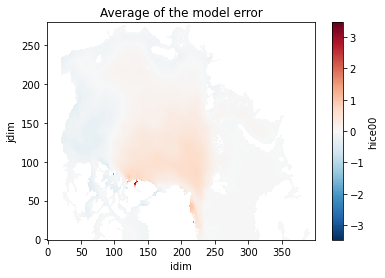

In [35]:
mu_a.plot()
plt.title('Average of the model error')

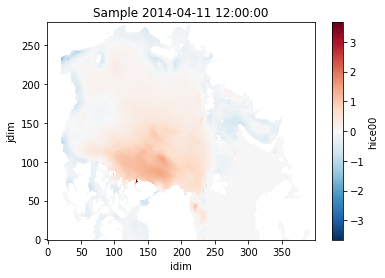

In [36]:
Xa.isel(rdim=idate).plot()
plt.title(f'Sample {chrono.iloc[idate]}');

Text(0.5, 1.0, 'Timeline over all SI')

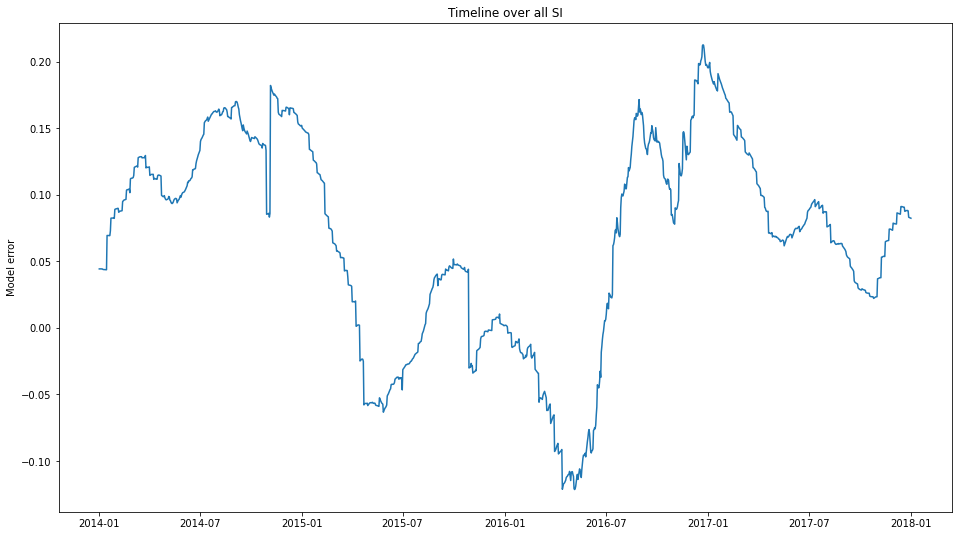

In [37]:
# to know how it evolves in time
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(16, 9))
ax.plot(chrono, Xa.mean(dim=['jdim','idim']))
ax.set_ylabel(f'Model error')

plt.title(f'Timeline over all SI')

In [38]:
# RMSE_a
RMSE_a = np.sqrt((np.square(Xa)).mean(dim='rdim'))

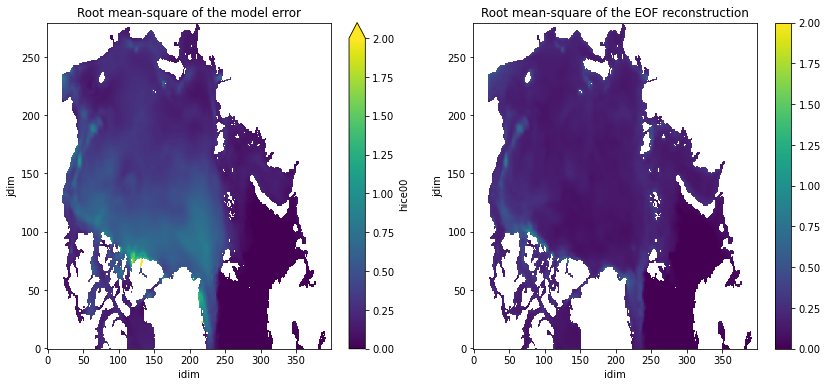

In [39]:
fig, ax = plt.subplots(ncols=2, figsize=(14,6))
RMSE_a.plot(vmax=2, ax = ax[0])
ax[0].set_title('Root mean-square of the model error');
RMSE_recf.plot(vmax=2, ax=ax[1])
ax[1].set_title('Root mean-square of the EOF reconstruction');


In [40]:
RMSA_a_av = RMSE_a.mean()
print(f'Average of the model error: {RMSA_a_av}')

Average of the model error: <xarray.DataArray 'hice00' ()>
array(0.2895862, dtype=float32)


In [41]:
Xa1d =  Xa.stack(z=('jdim','idim'))


In [42]:
Xa1d_nonan = Xa1d.where(mskok1d, drop=True)
Xa1d_nonan.shape

(1461, 60643)

In [43]:
pca_a = PCA(n_components=n_components)
pca_a.fit(Xa1d_nonan)

PCA(n_components=8)

In [44]:
pca_a.components_.shape
PCs_a = xr.DataArray(pca_a.transform(Xa1d_nonan), dims=['rdim','comp'])


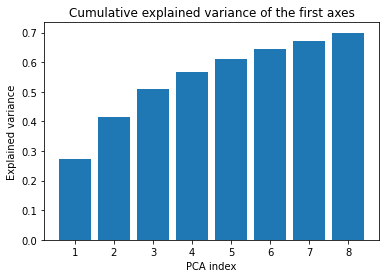

In [45]:
plt.bar(x=np.arange(n_components)+1,height=pca_a.explained_variance_ratio_.cumsum());
plt.title('Cumulative explained variance of the first axes')
plt.xlabel('PCA index')
plt.ylabel('Explained variance');

In [46]:
EOF1d_a = xr.DataArray(np.nan*np.ones ((n_components,Xa1d.shape[1])),dims=['comp','z'])
multi_index = pd.MultiIndex.from_tuples(Xf1d.coords['z'].data,names=['jdim','idim'])
EOF1d_a = EOF1d_a.assign_coords(z=('z',multi_index))
EOF1d_a[{'z':mskok1d}] = pca_a.components_
EOF2d_a= EOF1d_a.unstack('z')

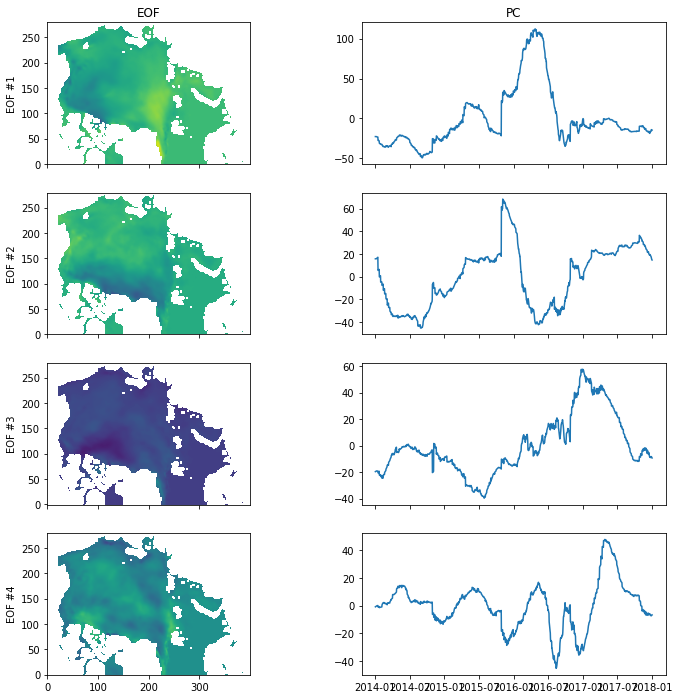

In [47]:
max_plot = 4
fig, ax = plt.subplots(ncols=2, nrows=max_plot,sharex='col', figsize=(12,max_plot*3))
for i in range(max_plot):
    ax[i, 0].imshow(EOF2d_a.isel(comp=i),origin='lower')
    ax[i, 1].plot(chrono, PCs_a[:,i])
    ax[i, 0].set_ylabel(f'EOF #{i+1}')
    
ax[0,0].set_title('EOF')
ax[0,1].set_title('PC');


In [48]:
# Reconstruction
Xa_rec = xr.dot(EOF2d_a,PCs_a)+ mu_a


Text(0.5, 1.0, 'EOF - True')

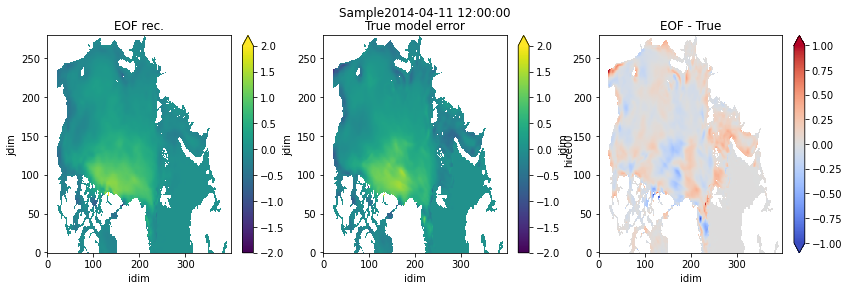

In [49]:
fig, ax = plt.subplots(ncols=3, figsize=(14,4))
fig.suptitle(f'Sample{chrono.iloc[idate]}')

Xa_rec.isel(rdim=idate).plot(ax=ax[0],vmin=-2, vmax=2)
Xa.isel(rdim=idate).plot(ax=ax[1],vmin=-2, vmax=2)
(Xa_rec-Xa).isel(rdim=idate).plot(ax=ax[2], vmin=-1, vmax=1, cmap=plt.get_cmap('coolwarm'))
ax[0].set_title('EOF rec.')
ax[1].set_title('True model error')
ax[2].set_title('EOF - True')

In [50]:
RMSE_reca = np.sqrt((np.square(Xa_rec-Xa)).mean(dim='rdim'))


Text(0.5, 1.0, 'the error reconstruction')

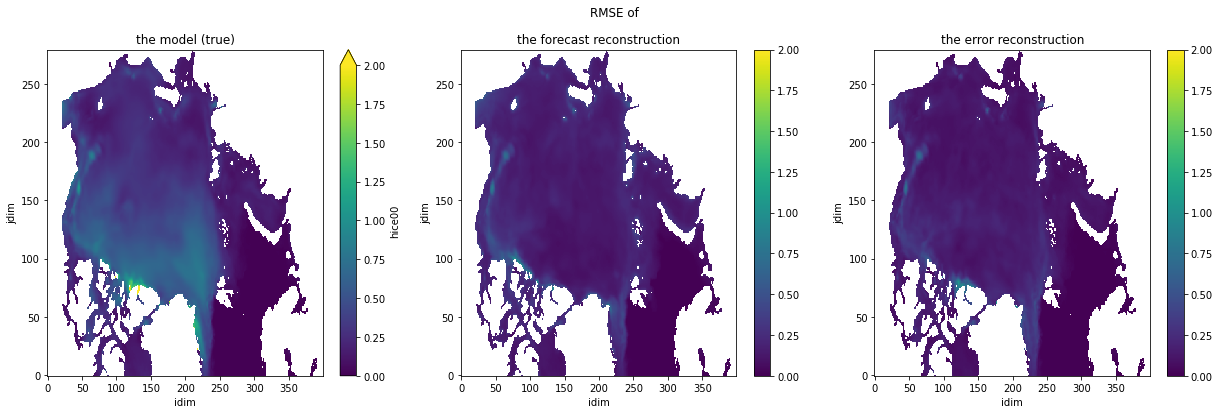

In [51]:
fig, ax = plt.subplots(ncols=3, figsize=(21,6))
fig.suptitle('RMSE of')
RMSE_a.plot(vmax=2, ax = ax[0])
ax[0].set_title('the model (true)');
RMSE_recf.plot(vmax=2, ax=ax[1])
ax[1].set_title('the forecast reconstruction');
RMSE_reca.plot(vmax=2, ax=ax[2])
ax[2].set_title('the error reconstruction')



In [52]:
RMSA_reca_av = RMSE_reca.mean()
print(f'Average of the model error reconstruction:{RMSA_reca_av}')

Average of the model error reconstruction:<xarray.DataArray ()>
array(0.12947518)


## PCA of the forcings

In [56]:
forcing_fields = ['airtmp', 'mslprs']

In [57]:
forcings = dict()
for field in forcing_fields:
    forcings[field] = np.load(os.path.join(rootdir, forcing_bdir, f'{field}.npy'))
Nf = len(forcing_fields) # Number of forcing fields

In [58]:
forcings['airtmp'].shape

(1461, 280, 400)

In [59]:
mu = dict()
pca = dict()
PCs = dict()
EOFs = dict()
for field in forcing_fields:
    X = forcings[field].reshape(forcings[field].shape[0],-1)
    mu[field] = np.mean(X, axis=0)
    pca[field] = PCA(n_components=n_components)
    pca[field].fit(X) # TODO train/val
    PCs[field] = pca[field].transform(X)
    EOFs[field] = pca[field].components_
#TODO: smooth forcing PC

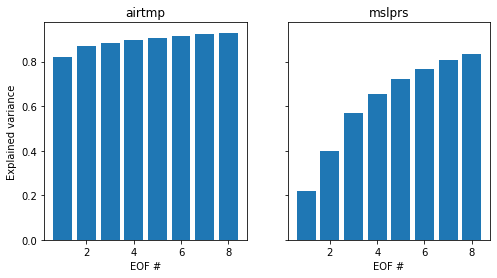

In [60]:
fig, ax = plt.subplots(ncols=Nf, sharey='all', figsize = (4*Nf, 4))
for i, field in enumerate(forcing_fields):
    ax[i].bar(x=np.arange(n_components)+1,height=pca[field].explained_variance_ratio_.cumsum())
    ax[i].set_title(field)
    ax[i].set_xlabel('EOF #')

ax[0].set_ylabel('Explained variance');


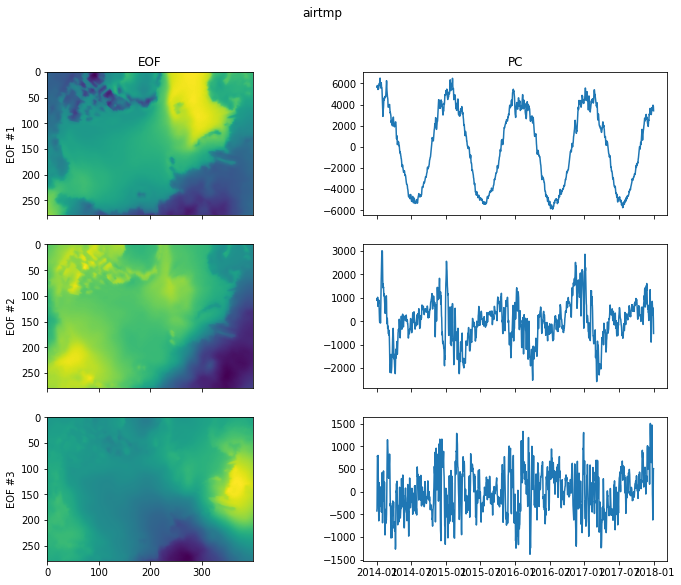

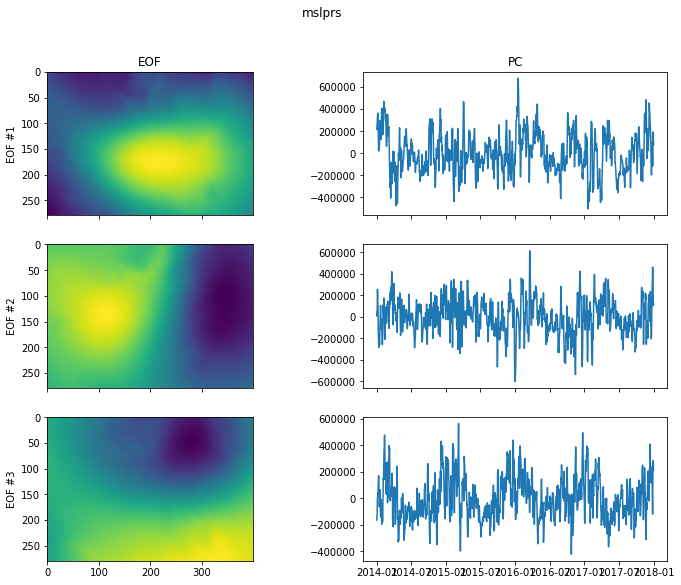

In [61]:
max_plot = 3

for field in forcing_fields:
    fig, ax = plt.subplots(ncols=2, nrows=max_plot,sharex='col', figsize=(max_plot*4, 9))
    for i in range(max_plot):
        ax[i, 0].imshow(EOFs[field][i].reshape(280,400))
        ax[i, 1].plot(chrono, PCs[field][:,i])
        ax[i, 0].set_ylabel(f'EOF #{i+1}')
    
    ax[0,0].set_title('EOF')
    ax[0,1].set_title('PC');
    fig.suptitle(field)

## Construct train/val/test dataset

In [62]:
# 3 types of predictors
# Xtp: The same as the target at t+1, (t+2, t+3, ...)
# Xnc: Forecast for the non corrected model at timet, ( t - N .. t+N
# Xfo: forcings at t (t-N, ..., t+N)
# We invert the time axis

Xtp = PCs_a.values[::-1][:-1]


Xnc = PCs_f.values[::-1][:-1]
Xfo  = np.concatenate([PCs[field] for field in forcing_fields],axis=1)[::-1][:-1]

X = np.concatenate((Xtp, Xnc, Xfo),axis=1)

y = PCs_a.values[::-1][1:]


In [63]:
nn = y.shape[0]
#Ideally one year of validation for hyperparameter tuning and one year of test
ntest = 365
nval = 360 #a bit less than one year to fit one more split
ntrain = nn - ntest - nval

nsplit = ntrain//nval +1
print(f'Number of split for CV: {nsplit}')

Number of split for CV: 3


In [64]:
pert = 1
Xtrain, ytrain = X[:ntrain+nval], y[:ntrain+nval]
print(f'Size of the training set: {ntrain}')
# Add some noise to the Xtp feature to avoid overfitting
nfeat = Xtp.shape[1]
sigma = np.std(Xtrain[:,:nfeat],keepdims=True)
noise = pert * np.random.randn(ntrain+nval, nfeat)

Xtrain[:,:nfeat] += noise



Size of the training set: 735


Text(0, 0.5, 'Perturbed input feature')

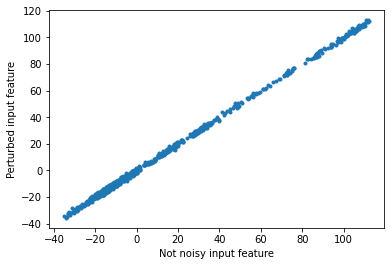

In [65]:
plt.plot(Xtrain[:,0] - noise[:,0], Xtrain[:,0],'.')
plt.xlabel('Not noisy input feature')
plt.ylabel('Perturbed input feature')

## A first simple model

In [66]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import RidgeCV, Ridge, ElasticNet
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


In [67]:
ts_cv = TimeSeriesSplit(
    n_splits=nsplit,
    gap=0,
    max_train_size=ntrain,
    test_size=nval,
)

def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error", "r2"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    r2 = cv_results["test_r2"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"R2:     {r2.mean():.3f} +/- {r2.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
        
    )




In [68]:
clf = make_pipeline(
    MinMaxScaler(),
    Ridge()
)

#clf = make_pipeline(
#    MinMaxScaler(),
#    RandomForestRegressor()
#)

print('Performance with the default values')
evaluate(clf, Xtrain, ytrain, ts_cv)


Performance with the default values
Mean Absolute Error:     11.918 +/- 4.362
R2:     -0.216 +/- 0.823
Root Mean Squared Error: 14.456 +/- 5.374


In [69]:
# Hyperparameter of the regressor
clf.get_params()

{'memory': None,
 'steps': [('minmaxscaler', MinMaxScaler()), ('ridge', Ridge())],
 'verbose': False,
 'minmaxscaler': MinMaxScaler(),
 'ridge': Ridge(),
 'minmaxscaler__clip': False,
 'minmaxscaler__copy': True,
 'minmaxscaler__feature_range': (0, 1),
 'ridge__alpha': 1.0,
 'ridge__copy_X': True,
 'ridge__fit_intercept': True,
 'ridge__max_iter': None,
 'ridge__normalize': 'deprecated',
 'ridge__positive': False,
 'ridge__random_state': None,
 'ridge__solver': 'auto',
 'ridge__tol': 0.001}

In [70]:
param_grid = {'ridge__alpha':[1e-3, 1e-2, 1e-1, 1, 10]}
#param_grid = {'elasticnet__alpha':[1e-3, 1e-2, 1e-1, 1, 10], 'elasticnet__l1_ratio':[.1, .25, .5, .75, .9]}
#param_grid = {'randomforestregressor__n_estimators': [50,100,200]}
grid = GridSearchCV (clf, param_grid= param_grid, cv=ts_cv)
grid.fit(Xtrain, ytrain)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=735, n_splits=3, test_size=360),
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [0.001, 0.01, 0.1, 1, 10]})

In [71]:
grid.cv_results_

{'mean_fit_time': array([0.00144577, 0.00142781, 0.00143123, 0.0014329 , 0.001429  ]),
 'std_fit_time': array([0.000189  , 0.00020395, 0.00021713, 0.00021283, 0.00020957]),
 'mean_score_time': array([0.00076429, 0.00075213, 0.00076524, 0.00077073, 0.00075436]),
 'std_score_time': array([2.35486545e-06, 6.14464499e-06, 4.64491501e-06, 1.33348733e-05,
        5.78461977e-06]),
 'param_ridge__alpha': masked_array(data=[0.001, 0.01, 0.1, 1, 10],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'ridge__alpha': 0.001},
  {'ridge__alpha': 0.01},
  {'ridge__alpha': 0.1},
  {'ridge__alpha': 1},
  {'ridge__alpha': 10}],
 'split0_test_score': array([-2.10733204, -2.09014528, -1.87406654, -1.2977937 , -0.97675151]),
 'split1_test_score': array([ 0.8006632 ,  0.79009038,  0.6804084 , -0.04886912, -1.27710234]),
 'split2_test_score': array([ 0.91928402,  0.91806629,  0.90104273,  0.69811076, -0.17553846]),
 'mean_test_score': ar

In [72]:
grid.best_params_

{'ridge__alpha': 0.1}

In [73]:
evaluate(grid.best_estimator_, Xtrain, ytrain, ts_cv)


Mean Absolute Error:     9.289 +/- 5.021
R2:     -0.098 +/- 1.259
Root Mean Squared Error: 11.359 +/- 5.964


In [74]:
ypredict = grid.predict(X)

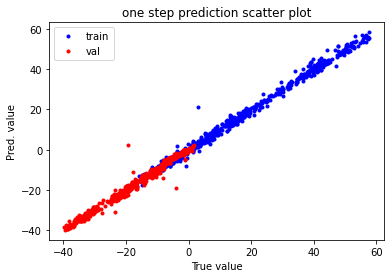

In [75]:
plt.plot(y[:ntrain,2],ypredict[:ntrain,2],'.b', label='train')
plt.plot(y[ntrain:,2],ypredict[ntrain:,2],'.r', label='val')
plt.legend()
plt.xlabel('True value')
plt.ylabel('Pred. value');
plt.title('one step prediction scatter plot');

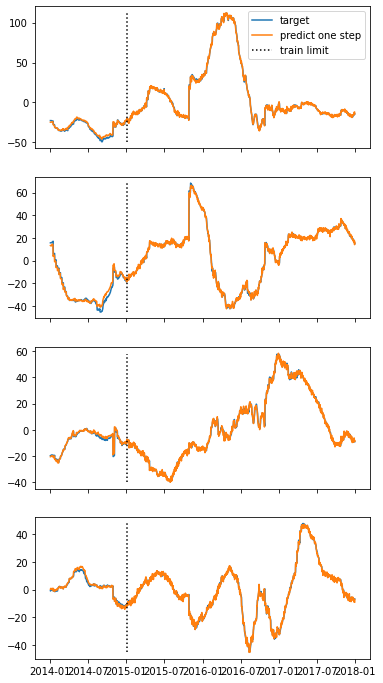

In [76]:
max_plot = 4
fig, ax = plt.subplots(ncols=1, nrows=max_plot,sharex='col', figsize=(6,max_plot*3))

for i in range(max_plot):
    ax[i].plot(chrono[:-1],y[::-1,i], label='target')
    ax[i].plot(chrono[:-1],ypredict[::-1,i],label='predict one step')
    mini, maxi = y[:,i].min(), y[:,i].max()
    ax[i].plot([chrono.iloc[ntest], chrono.iloc[ntest]], [mini, maxi],':k',label='train limit')
    
ax[0].legend()


In [77]:
# recursive prediction
nsample = y.shape[0]
yrec = np.zeros((nsample, nfeat))
teacher = False
nteacher = 1
for it in range(nsample):
    x0 = X[it:it+1].copy()
    if (it>nteacher) and (not teacher):
        x0[:,:nfeat] = yrec[it-1]
    yrec[it,:] = grid.predict(x0)

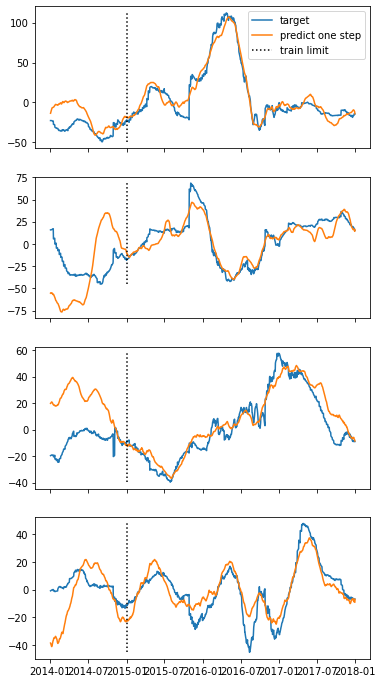

In [78]:
max_plot = 4
fig, ax = plt.subplots(ncols=1, nrows=max_plot,sharex='col', figsize=(6,max_plot*3))

for i in range(max_plot):
    ax[i].plot(chrono[:-1],y[::-1,i], label='target')
    ax[i].plot(chrono[:-1],yrec[::-1,i],label='predict one step')
    mini, maxi = y[:,i].min(), y[:,i].max()
    ax[i].plot([chrono.iloc[ntest], chrono.iloc[ntest]], [mini, maxi],':k',label='train limit')
    
ax[0].legend()


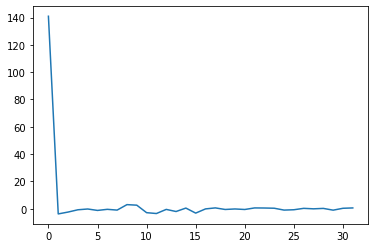

In [89]:
i =0
plt.plot(grid.best_estimator_['ridge'].coef_[i,:])

In [80]:
PCA_est =  np.zeros_like(PCs_a.values)
PCA_est[:-1] = yrec[::-1]
PCA_est = xr.DataArray(PCA_est, dims=['rdim','comp'])

In [81]:
# Reconstruction
Xc = xr.dot(EOF2d_a,PCA_est)+ mu_a


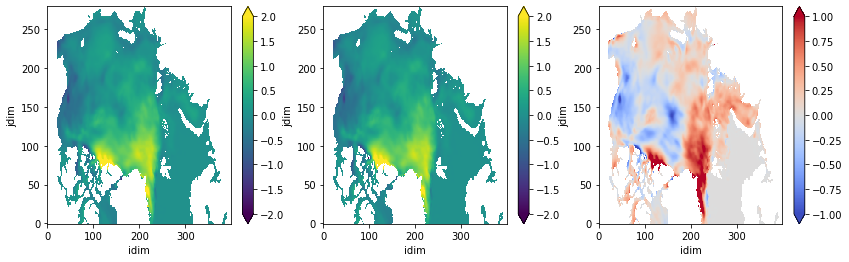

In [82]:
fig, ax = plt.subplots(ncols=3, figsize=(14,4))
Xc.isel(rdim=idate).plot(ax=ax[0],vmin=-2, vmax=2)
Xc.isel(rdim=idate).plot(ax=ax[1],vmin=-2, vmax=2)
(Xc-Xa).isel(rdim=idate).plot(ax=ax[2], vmin=-1, vmax=1, cmap=plt.get_cmap('coolwarm'));


In [83]:
print(f'Size of the test:{ntest}')
RMSE_corr = np.sqrt((np.square(Xc.isel(rdim=slice(None,ntest))-Xa.isel(rdim=slice(None,ntest)))).mean(dim='rdim'))


Size of the test:365


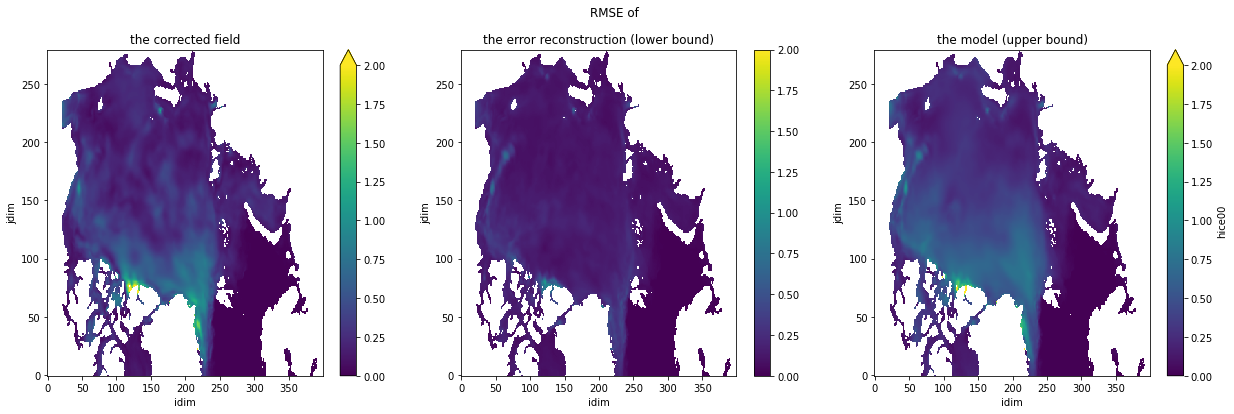

In [84]:
fig, ax = plt.subplots(ncols=3, figsize=(21,6))
fig.suptitle('RMSE of')
RMSE_corr.plot(vmax=2, ax = ax[0])
ax[0].set_title('the corrected field');
RMSE_reca.plot(vmax=2, ax=ax[1])
ax[1].set_title('the error reconstruction (lower bound)');
RMSE_a.plot(vmax=2, ax=ax[2])
ax[2].set_title('the model (upper bound)');



In [85]:
RMSE_corr_av = RMSE_corr.mean()
print(f'Average of the corrected model error (lower bound):{RMSE_corr_av.values:.2f}')
print(f'Average of the model error reconstruction (lower bound):{RMSA_reca_av.values:.2f}')
print(f'Average of the model error (upper bound): {RMSA_a_av.values:.2f}')



Average of the corrected model error (lower bound):0.25
Average of the model error reconstruction (lower bound):0.13
Average of the model error (upper bound): 0.29


In [86]:
Xa_start = Xa.isel(rdim=slice(None,2*ntest))
Xc_start = Xc.isel(rdim=slice(None,2*ntest))
Xf_start = Xf.isel(rdim=slice(None,2*ntest))
Xt_start = Xa_start + Xf_start
Xn_start = Xc_start + Xf_start

In [87]:
RMSE_f_t = np.sqrt((np.square(Xa_start)).mean(dim=('idim','jdim')))
RMSE_c_t = np.sqrt((np.square(Xc_start-Xa_start)).mean(dim=('idim','jdim')))



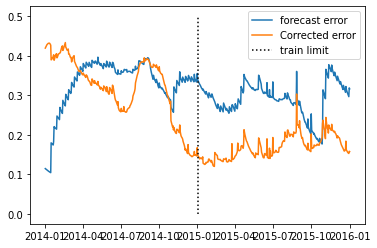

In [88]:
fig, ax = plt.subplots()
ax.plot(chrono.iloc[:2*ntest], RMSE_f_t, label='forecast error')
ax.plot(chrono.iloc[:2*ntest], RMSE_c_t, label='Corrected error')
ax.plot([chrono.iloc[ntest]]*2,[0.0, 0.50], ':k', label='train limit')
ax.legend()